In [1]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools, Descriptors
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

/Users/mahadgatti/mambaforge/envs/testing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
HERE = Path(_dh[-1])

Next, we create resource objects for API access.

In [3]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [4]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

### Get target data (ABL-1 kinase)

* Get UniProt ID of the target of interest (ABL-1 kinase:  [P00519](http://www.uniprot.org/uniprot/P00519)) from [UniProt website](https://www.uniprot.org/)

Select a different UniProt ID, if you are interested in another target.

In [5]:
uniprot_id = "P00519"

#### Fetch target data from ChEMBL

In [6]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL1862,SINGLE PROTEIN
1,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL1862,SINGLE PROTEIN
2,Homo sapiens,Bcr/Abl fusion protein,CHEMBL2096618,CHIMERIC PROTEIN
3,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL2111414,PROTEIN FAMILY
4,Homo sapiens,Ras and Rab interactor 1/Tyrosine-protein kina...,CHEMBL3885630,PROTEIN-PROTEIN INTERACTION
5,Homo sapiens,Transcription factor ETV6/Tyrosine-protein kin...,CHEMBL3885645,CHIMERIC PROTEIN
6,Homo sapiens,Baculoviral IAP repeat-containing protein 2/BC...,CHEMBL4296119,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,E3 ubiquitin-protein ligase XIAP/BCR/ABL,CHEMBL4296120,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Cereblon/BCR/ABL,CHEMBL4296137,PROTEIN-PROTEIN INTERACTION
9,Homo sapiens,VHL/ABL1,CHEMBL4523725,PROTEIN-PROTEIN INTERACTION


#### Select target (target ChEMBL ID)

After checking the entries, we select the first entry as our target of interest:

`CHEMBL1862`

In [7]:
target = targets.iloc[0]
target

organism                           Homo sapiens
pref_name           Tyrosine-protein kinase ABL
target_chembl_id                     CHEMBL1862
target_type                      SINGLE PROTEIN
Name: 0, dtype: object

Save selected ChEMBL ID.

In [8]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL1862


### Get bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Fetch bioactivity data for the target from ChEMBL

In this step, we fetch the bioactivity data and filter it to only consider

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [9]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}")

Length and type of bioactivities object: 2307


Each entry in our bioactivity set holds the following information:

In [10]:
bioactivities[0]

{'activity_id': 146141,
 'assay_chembl_id': 'CHEMBL806527',
 'assay_description': 'Radioligand displacement assay for the binding of [125I]Glu-Pro-Gln-pTyr-Glu-Glu-Ile-Pro-Ile-Tyr-Leu to ABL SH2 domain',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL13462',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '4000.0',
 'target_chembl_id': 'CHEMBL1862',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '4.0'}

#### Download bioactivity data from ChEMBL

Finally, we download the `QuerySet` in the form of a `pandas` `DataFrame`. 


In [11]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (2307, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50,uM,4.0
1,146143,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL13462,=,nM,16000.0,CHEMBL1862,Homo sapiens,IC50,uM,16.0
2,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50,uM,15.0
3,148571,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL414123,=,nM,2900.0,CHEMBL1862,Homo sapiens,IC50,uM,2.9
4,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50,uM,1.8


In [12]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'M', 'microM', "10'-6M", "10'-8M", "10'-7M", '10^-8M'],
      dtype=object)

In [13]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,146143,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL13462,=,nM,16000.0,CHEMBL1862,Homo sapiens,IC50
2,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
3,148571,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL414123,=,nM,2900.0,CHEMBL1862,Homo sapiens,IC50
4,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50


#### Preprocess and filter bioactivity data

1. Convert `standard_value`'s datatype from `object` to `float`
2. Delete entries with missing values
3. Keep only entries with `standard_unit == nM`
4. Delete duplicate molecules
5. Reset `DataFrame` index
6. Rename columns

**1. Convert datatype of "standard_value" from "object" to "float"**

The field `standard_value` holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.

In [14]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [15]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. Delete entries with missing values**

Use the parameter `inplace=True` to drop values in the current `DataFrame` directly.

In [16]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2307, 11)


**3. Keep only entries with "standard_unit == nM"** 

We only want to keep bioactivity entries in `nM`, thus we remove all entries with other units.

In [17]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [18]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [19]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2307, 11)


**4. Delete duplicate molecules**

Sometimes the same molecule (`molecule_chembl_id`) has been tested more than once, in this case, we only keep the first one.

Note other choices could be to keep the one with the best value or a mean value of all assay results for the respective compound.

In [20]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (1476, 11)


**5. Reset "DataFrame" index**

Since we deleted some rows, but we want to iterate over the index later, we reset the index to be continuous.

In [21]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
2,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50
3,154553,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL301845,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
4,159483,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL58478,=,nM,1700.0,CHEMBL1862,Homo sapiens,IC50


**6. Rename columns**

In [22]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
2,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50
3,154553,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL301845,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
4,159483,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL58478,=,nM,1700.0,CHEMBL1862,Homo sapiens,IC50


In [23]:
print(f"DataFrame shape: {bioactivities_df.shape}")
number_of_cpds = bioactivities_df.shape[0]

DataFrame shape: (1476, 11)


We now have a set of molecule ids with respective IC50 values for our target.

#### Fetch compound data from ChEMBL

Let's have a look at the compounds from ChEMBL which we have defined bioactivity data for: We fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [24]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

#### Download compound data from ChEMBL

Again, we want to export the `QuerySet` object into a `pandas.DataFrame`. Given the data volume, **this can take some time.** For that reason, we will first obtain the list of records through `tqdm`, so we get a nice progress bar and some ETAs. We can then pass the list of compounds to the DataFrame.

In [25]:
compounds = list(tqdm(compounds_provider))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1476/1476 [00:34<00:00, 42.79it/s]


In [26]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1476, 2)


In [27]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL44,{'canonical_smiles': 'O=c1c(-c2ccc(O)cc2)coc2c...
1,CHEMBL9514,{'canonical_smiles': 'COC(=O)Nc1nc2cc(C(=O)c3c...
2,CHEMBL13462,{'canonical_smiles': 'CC(=O)N[C@@H](Cc1ccc(OP(...
3,CHEMBL276711,{'canonical_smiles': 'Cc1cc(C)c(/C=C2\C(=O)Nc3...
4,CHEMBL535,{'canonical_smiles': 'CCN(CC)CCNC(=O)c1c(C)[nH...


#### Preprocess and filter compound data

1. Remove entries with missing entries
2. Delete duplicate molecules (by molecule_chembl_id)
3. Get molecules with canonical SMILES

**1. Remove entries with missing molecule structure entry**

In [28]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1474, 2)


**2. Delete duplicate molecules**

In [29]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1474, 2)


**3. Get molecules with canonical SMILES**

So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [30]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [31]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1474, 2)


Sanity check: Remove all molecules without a canonical SMILES string.

In [32]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1474, 2)


### Output (bioactivity-compound) data
**Summary of compound and bioactivity data**

In [33]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 1476


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [34]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 1474


Index(['molecule_chembl_id', 'smiles'], dtype='object')

#### Merge both datasets

Merge values of interest from `bioactivities_df` and `compounds_df` in an `output_df` based on the compounds' ChEMBL IDs (`molecule_chembl_id`), keeping the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* units: `units`
* IC50: `IC50`

In [35]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 1474 entries.


In [36]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [37]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL13462,4000.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,CHEMBL414123,15000.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
2,CHEMBL413629,1800.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
3,CHEMBL301845,15000.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...
4,CHEMBL58478,1700.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...
5,CHEMBL298813,1600.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc...
6,CHEMBL293803,4900.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
7,CHEMBL294692,1200.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...
8,CHEMBL294420,1200.0,nM,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...
9,CHEMBL299477,7900.0,nM,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...


#### Add pIC50 values

As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [38]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [39]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [40]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL13462,4000.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.397940
1,CHEMBL414123,15000.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,4.823909
2,CHEMBL413629,1800.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,5.744727
3,CHEMBL301845,15000.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...,4.823909
4,CHEMBL58478,1700.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...,5.769551


#### Draw compound data

Let's have a look at our collected data set.

First, we plot the pIC50 value distribution as well as the median pIC50 which will be useful for classification thresholds

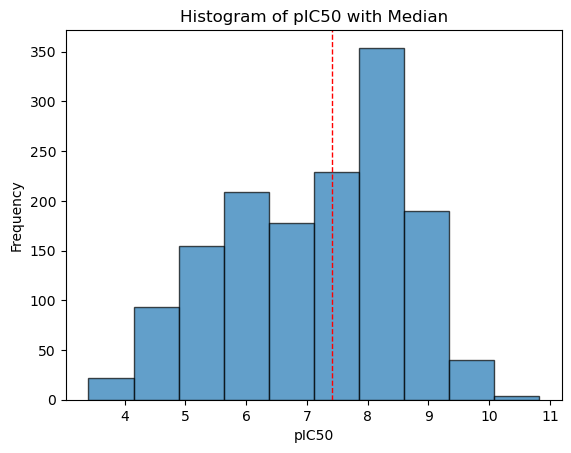

In [41]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(output_df['pIC50'], bins=10, edgecolor='black', alpha=0.7)

# Calculate the median of the "pIC50" column
median_pIC50 = output_df['pIC50'].median()

# Add a vertical line for the median
plt.axvline(median_pIC50, color='red', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.title('Histogram of pIC50 with Median')

# Display the plot
plt.show()


In the next steps, we add a column for RDKit molecule objects to our `DataFrame` and look at the structures of the molecules with the highest pIC50 values. 

In [42]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [43]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

Show the three most active molecules, i.e. molecules with the highest pIC50 values.

In [44]:
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL2347725,0.015,nM,10.823909,<rdkit.Chem.rdchem.Mol object at 0x130f6b5a0>
1,CHEMBL2347722,0.021,nM,10.677781,<rdkit.Chem.rdchem.Mol object at 0x130f6b6f0>
2,CHEMBL2347723,0.064,nM,10.193820,<rdkit.Chem.rdchem.Mol object at 0x130f6b680>


### Uncomment if you want to remove the ROMol column

In [45]:
# Prepare saving the dataset: Drop the ROMol column
#output_df = output_df.drop("ROMol", axis=1)
#print(f"DataFrame shape: {output_df.shape}")

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,
...,...,...,...,...,...,...
1469,CHEMBL551838,236000.000,nM,Cc1ccc(C(=O)Nc2cc(C(F)(F)F)ccc2F)cc1/C=C/n1cnc...,3.627088,
1470,CHEMBL551030,243000.000,nM,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1/C=C/n1cnc2...,3.614394,
1471,CHEMBL559438,267000.000,nM,Cc1ccc(C(=O)Nc2ncc(C(C)(C)C)s2)cc1/C=C/n1cnc2c...,3.573489,
1472,CHEMBL3105076,380000.000,nM,Nc1ncnc2[nH]c(C(F)(F)F)nc12,3.420216,

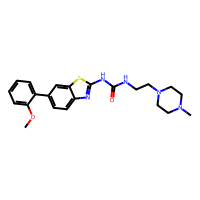
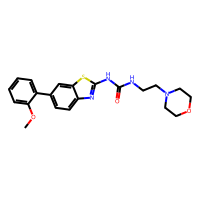
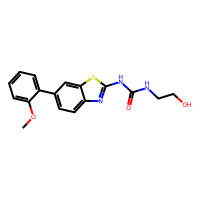
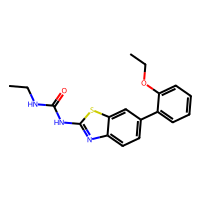
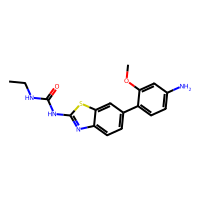
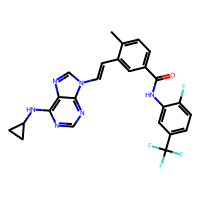
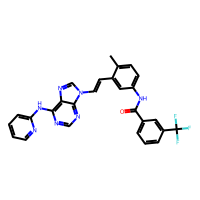
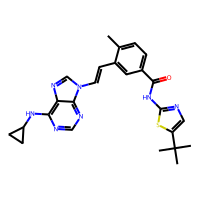
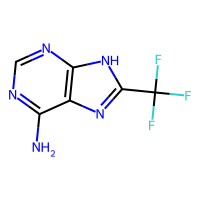
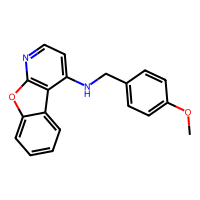

In [46]:
output_df

#### Apply physchem filters
Considering a typical user might try multiple Uniprot IDs, I thought it would make sense to add some physchem filters to avoid peptides or other unwanted structures.
Users are encouraged to change such parameters to suit their applications best.

In [47]:
def check_lipinski_rule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mw = Descriptors.MolWt(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        return mw <= 700 and logp <= 5 and hbd <= 5 and hba <= 10 and tpsa <=120
    return False

In [48]:
output_df['Passes_Lipinski'] = output_df['smiles'].apply(check_lipinski_rule)


In [49]:
passed_molecules_df = output_df[output_df['Passes_Lipinski']]


In [50]:
#passed_molecules_df

In [51]:
output_df['Passes_Lipinski'].value_counts()

Passes_Lipinski
True     1046
False     428
Name: count, dtype: int64

#### Write output data to file

Save both the unfiltered and filtered sets using the chembl_id as prefix.

In [52]:
output_df.to_csv(f'{uniprot_id}_unfiltered.csv')

In [53]:
passed_molecules_df.to_csv(f'{uniprot_id}_filtered.csv')

In [54]:
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (1474, 7)


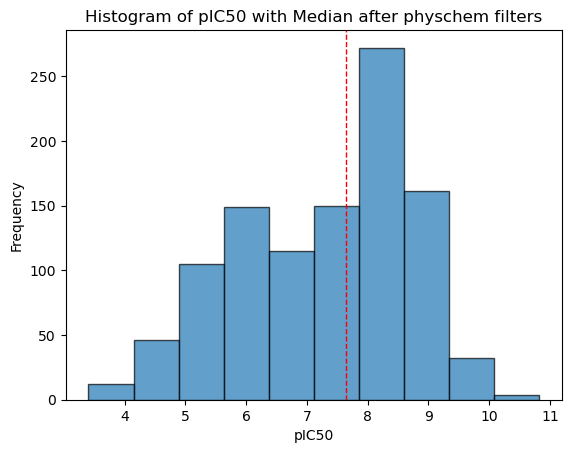

In [55]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(passed_molecules_df['pIC50'], bins=10, edgecolor='black', alpha=0.7)

# Calculate the median of the "pIC50" column
median_pIC50 = passed_molecules_df['pIC50'].median()

# Add a vertical line for the median
plt.axvline(median_pIC50, color='red', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.title('Histogram of pIC50 with Median after physchem filters')

# Display the plot
plt.show()


## Import libraries for Regression and Classification models

In this example, Random forest and SVM are used for regression and classification.
Fingerprints are calculated using RDKIT.
For the classification model, we will use the median of pIC50 as activity threshold.

In [56]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_validate
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC


### Calculate Molecular Fingerprints

In [57]:
generator = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=1024, includeChirality=True)

In [58]:
X = np.stack([generator.GetCountFingerprintAsNumPy(Chem.MolFromSmiles(x)) for x in passed_molecules_df["smiles"]])

In [59]:
Y = passed_molecules_df['pIC50'].values

### Prepare Training and Testing set

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

### Train Random Forest Regression model and calculate MSE

In [61]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)


In [62]:
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [63]:
y_pred = rf_regressor.predict(X_test)


In [64]:
mse = mean_squared_error(y_test, y_pred)
print(mse)


0.5336607016539845


### Define classification labels based on median pIC50
Molecules with pIC50 above the median will be considered as class "1" otherwise as "0"

In [65]:
passed_molecules_df['label'] = passed_molecules_df['pIC50'].apply(lambda x: 1 if x >= median_pIC50 else 0)

/var/folders/yx/h7g3cmg55z710gshz7fty5d40000gp/T/ipykernel_32714/2972337964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed_molecules_df['label'] = passed_molecules_df['pIC50'].apply(lambda x: 1 if x >= median_pIC50 else 0)


In [66]:
output_df['label'] = output_df['pIC50'].apply(lambda x: 1 if x >= median_pIC50 else 0)

### Prepare Training and Testing set for Classification with SVM

In [67]:
Y_cla = passed_molecules_df['label'].values

In [68]:
X_train_cla, X_test_cla, y_train_cla, y_test_cla = train_test_split(X, Y_cla, test_size=0.2, random_state=42)


In [69]:
svm_model = SVC(kernel='poly', random_state=42)

In [70]:
svm_model.fit(X_train_cla, y_train_cla)

SVC(kernel='poly', random_state=42)

In [71]:
y_pred_cla = svm_model.predict(X_test_cla)

### Calculate Accuracy, MCC and plot confusion matrix

In [72]:
accuracy = accuracy_score(y_test_cla, y_pred_cla)
print("Accuracy:", accuracy)

# Print classification report (includes precision, recall, F1-score, and support)
print("Classification Report:")
print(classification_report(y_test_cla, y_pred_cla))
print("MCC:")
print(matthews_corrcoef(y_test_cla, y_pred_cla))

Accuracy: 0.861904761904762
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       101
           1       0.86      0.87      0.87       109

    accuracy                           0.86       210
   macro avg       0.86      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210

MCC:
0.7233405121113933


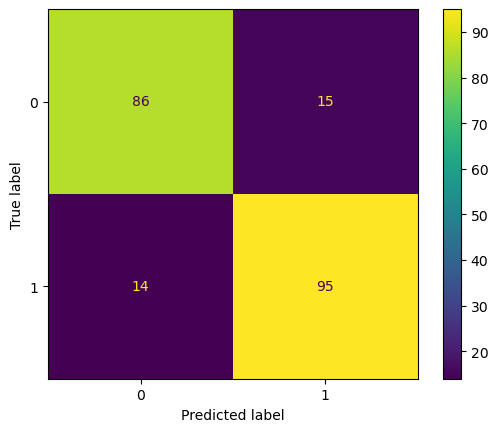

In [73]:
ConfusionMatrixDisplay.from_predictions(y_test_cla, y_pred_cla)

## Bonus

### Use Chemplot tool to visualise UMAP of the dataset collected in the previous steps.

In [74]:
import chemplot as cp

/Users/mahadgatti/mambaforge/envs/testing/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mahadgatti/mambaforge/envs/testing/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mahadgatti/mambaforge/envs/testing/lib/python3.11

In [75]:
plotter = cp.Plotter.from_smiles(passed_molecules_df["smiles"], target=passed_molecules_df["label"], target_type="C")

sim_type indicates the similarity type by which the plots are constructed.
The supported similarity types are structural and tailored.
Because a target list has been provided 'tailored' as been selected as sym_type.


/Users/mahadgatti/mambaforge/envs/testing/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [76]:
plotter.umap()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,UMAP-1,UMAP-2,target
0,6.530849,4.165096,1
1,6.444770,4.230944,1
2,5.593680,4.565427,1
3,5.619543,4.742915,1
4,5.655399,4.581794,1
...,...,...,...
1041,8.744580,10.977546,0
1042,5.898918,10.627969,0
1043,17.786648,6.645277,0
1044,2.361543,6.858893,0


<Axes: label='scatter', title={'center': 'UMAP plot'}, xlabel='UMAP-1', ylabel='UMAP-2'>

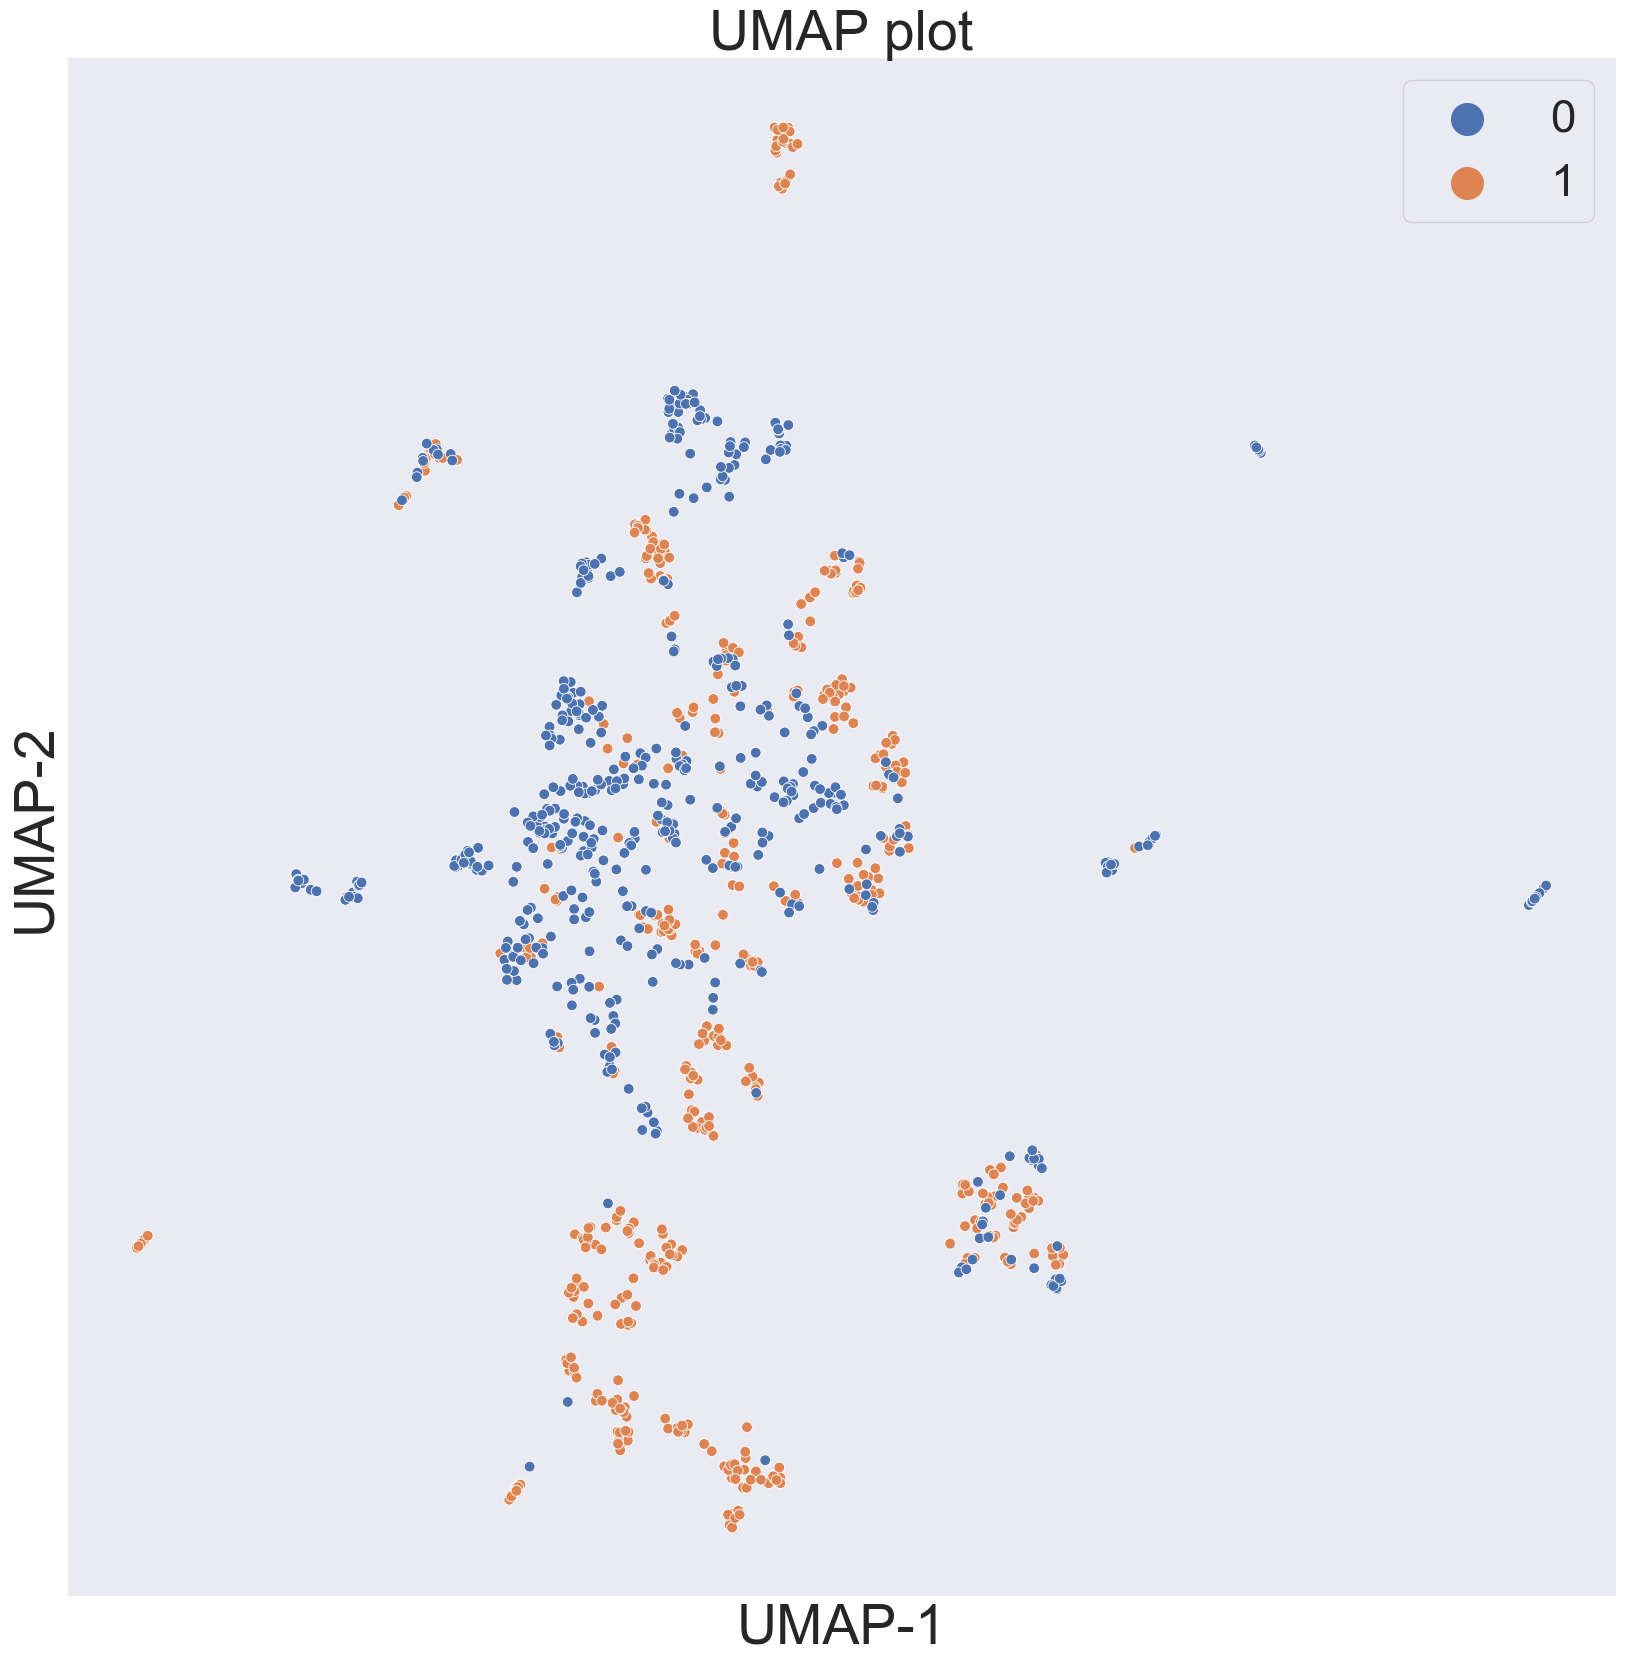

In [77]:
plotter.visualize_plot()


## If you prefer an interactive plot, uncomment and run the below line

In [78]:
#plotter.interactive_plot(show_plot=True)
